In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os, random, glob
from PIL import Image
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input, Reshape, Rescaling, Activation, Bidirectional, LSTM, Lambda, GRU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


## DATA PREPROCESSING


In [43]:
# Path to dataset folder containing CAPTCHA images stored locally
dataset_path = "C:\\Users\\Evan\\Desktop\\deeplearning\\captcha_dataset\\samples"

# Define the set of characters used by the CAPTCHAs
characters = '0123456789abcdefghijklmnopqrstuvwxyz'

# Instantiate dictionaries to map characters and integers
char_to_index = {char: index for index, char in enumerate(characters)}
index_to_char = {v: k for k, v in char_to_index.items()}

# Lists to hold loaded images and text labels
images = []
labels = []


# Load images and labels
for file_name in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, file_name)
    
    # Open and convert image to grayscale to reduce channel to 1 and simplify data augmentation
    img = Image.open(image_path).convert('L')
    
    # Extract label from file name
    label = file_name.split('.')[0]
    
    # Append the numpy array of the image and append the label to list
    images.append(np.array(img))
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)  
labels = np.array(labels)

print("Initial image shape (before channel expansion):", images.shape)
print("Sample label (first):", labels[0])

# Expand image dimensions to (N, H, W, 1) for grayscale channel for TensorFlow compatibility
images = np.expand_dims(images, axis=-1)
print("Image shape after adding channel dimension:", images.shape)

# Resize each image to (64, 128)
images_resized = np.array([
    tf.image.resize(img, (64, 128)).numpy() for img in images
])
print("After resizing, images shape:", images_resized.shape)

# Convert characters in label array to integer equivalent
def label_to_indices(lbl):
    return [char_to_index[ch] for ch in lbl]

# Convert text labels to integer sequences
labels_indices = [label_to_indices(lbl) for lbl in labels]

# Find the maximum label length in the dataset
max_label_length = max(len(seq) for seq in labels_indices)
print("Max label length:", max_label_length)

# Pad label sequences so they all have the same length
labels_indices_padded = np.zeros((len(labels_indices), max_label_length), dtype=int)
for i, seq in enumerate(labels_indices):
    labels_indices_padded[i, :len(seq)] = seq

print("Shape of padded labels array:", labels_indices_padded.shape)
print("First padded label indices:", labels_indices_padded[0])


# Split the dataset into train/validation/test sets
# 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    images_resized, 
    labels_indices_padded, 
    test_size=0.3, 
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42
)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

Initial image shape (before channel expansion): (1040, 50, 200)
Sample label (first): 226md
Image shape after adding channel dimension: (1040, 50, 200, 1)
After resizing, images shape: (1040, 64, 128, 1)
Max label length: 5
Shape of padded labels array: (1040, 5)
First padded label indices: [ 2  2  6 22 13]
X_train shape: (728, 64, 128, 1) y_train shape: (728, 5)
X_val shape: (156, 64, 128, 1) y_val shape: (156, 5)
X_test shape: (156, 64, 128, 1) y_test shape: (156, 5)


## Data Augmentation

In [44]:
def augment_image(image):
    # image shape => (height, width, 1)
    # We'll apply random contrast, brightness, horizontal flip
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_flip_left_right(image)
    return image

def augment_data(images, labels):
    # images in shape (batch, 64, 128, 1)
    # Vectorized_map for each sample in the batch
    images = tf.vectorized_map(augment_image, images)
    return images, labels

## Datasets

In [45]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Model

In [46]:
input_data = Input(shape=(64, 128, 1), name='input_image')

# Converts input to float32
# Rescaling is actually done in preprocessing
x = Rescaling(1./1)(input_data)   

# Transpose to (batch, width, height, 1) so model reads left to right
x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

# Conv2d + BN + MaxPool 1
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# Conv2d + BN + MaxPool 2
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# Conv2d + BN + MaxPool 3
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1))(x)

# Reshape for RNN (batch, time_steps, features)
# (batch, width=16, height=16, channels=256)
# Interpret width as time dimension=16
x = Reshape(target_shape=(16, 16 * 256))(x)

# Dense + dropout 1
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
# BiLSTM 1
x = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.25))(x)

# Dense + dropout 2
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
# BiLSTM 2
x = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.25))(x)

# softmax
output = Dense(len(characters) + 1, activation='softmax')(x)

model = Model(inputs=input_data, outputs=output)

# CTC loss
def ctc_loss(y_true, y_pred):
    # input_length: batch_size x 1
    input_length = tf.fill([tf.shape(y_pred)[0], 1], tf.shape(y_pred)[1])
    # label_length: batch_size x 1
    label_length = tf.fill([tf.shape(y_true)[0], 1], max_label_length)
    return ctc_batch_cost(y_true, y_pred, input_length, label_length)

model.compile(optimizer=Adam(), loss=ctc_loss)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 64, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 64, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transpose (Lambda)                   │ (None, 128, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 64, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 64, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16, 128)             │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 16, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 16, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16, 37)              │          18,9

 Total params: 2,557,477 (9.76 MB)

 Trainable params: 2,556,581 (9.75 MB)

 Non-trainable params: 896 (3.50 KB)

In [47]:
# debugging step to ensure images and labels shaped appropriately
sample = next(iter(train_dataset))
print("Sample images shape:", sample[0].shape)
print("Sample labels shape:", sample[1].shape)

Sample images shape: (16, 64, 128, 1)
Sample labels shape: (16, 5)


## Train Model

In [64]:
num_epochs = 20
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',
            patience=5,
            restore_best_weights=True,
        )
    ]
)

test_loss = model.evaluate(test_dataset)
print("Test Loss:", test_loss)

def print_final_metrics(history):
    hist = history.history
    final_epoch = len(hist['loss']) - 1
    print(f"Final epoch: {final_epoch+1}")
    for k in hist.keys():
        final_val = hist[k][final_epoch]
        print(f"{k}: {final_val:.4f}")

print_final_metrics(history)

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.2146 - val_loss: 0.2083
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2270
Test Loss: 0.22434765100479126
Final epoch: 1
loss: 0.2170
val_loss: 0.2083


## Decoding Predictions

In [55]:
def decode_predictions(pred):
    # Array indicating sequence lengths
    input_length = tf.fill((tf.shape(pred)[0],), tf.shape(pred)[1])
    # Call ctc_decode
    decoded, _ = tf.keras.backend.ctc_decode(
    pred, 
    input_length=input_length, 
    greedy=False,             
    # use beam search
    beam_width=5,             
    )
    # Convert path from list to NumPy array
    decoded = decoded[0].numpy()
    # Map decoded sequences back to text
    decoded_texts = []
    for seq in decoded:
        # Convert character index to character if not blank
        decoded_texts.append("".join([index_to_char[c] for c in seq if c != -1]))
    return decoded_texts

sample_batch = next(iter(test_dataset))
images, labels = sample_batch  

# predictions follow shape (batch_size, time_steps, num_classes)
predictions = model.predict(images)
decoded_texts = decode_predictions(predictions)

# Compare predicted and true labels
for i in range(15):
    # Convert each row of labels to np.array
    label_np = labels[i].numpy()  # (max_label_length,)
    # Filter out zero-padded indices, then map them to characters
    true_label = ''.join(index_to_char[idx] for idx in label_np if idx != 0)
    
    predicted = decoded_texts[i]
    # Check if they match
    match_str = " (MATCH)" if true_label == predicted else " (NO MATCH)"

    print(f"True: {true_label} | Predicted: {predicted}{match_str}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
True: eppg3 | Predicted: epg3 (NO MATCH)
True: bd3b7 | Predicted: bd3b7 (MATCH)
True: xbem6 | Predicted: xbem6 (MATCH)
True: dn2ym | Predicted: dn2ym (MATCH)
True: c3n8x | Predicted: c3n8x (MATCH)
True: yyn57 | Predicted: yn57 (NO MATCH)
True: 55y2m | Predicted: 52m (NO MATCH)
True: 2xc2n | Predicted: 2xc2n (MATCH)
True: yy824 | Predicted: y824 (NO MATCH)
True: c7gb3 | Predicted: c7gb3 (MATCH)
True: 7w67m | Predicted: 7w67m (MATCH)
True: ecd4w | Predicted: cd4w (NO MATCH)
True: w4cdc | Predicted: w4cdc (MATCH)
True: nn4wx | Predicted: n4wx (NO MATCH)
True: 6fn84 | Predicted: 6fn84 (MATCH)


## Evaluation Functions

In [56]:
# Calculate number of edits required to transform one string into another string - edit distance
def levenshtein_distance(s1, s2):

    m, n = len(s1), len(s2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
    return dp[m][n]

def build_confusion_matrix(charset):

    char_to_idx = {c: i for i, c in enumerate(charset)}
    matrix = np.zeros((len(charset), len(charset)), dtype=int)
    return matrix, char_to_idx

def update_confusion_matrix(matrix, char_to_idx, true_char, pred_char):

    if true_char in char_to_idx and pred_char in char_to_idx:
        i = char_to_idx[true_char]
        j = char_to_idx[pred_char]
        matrix[i, j] += 1

def plot_confusion_matrix(conf_mat, characters, normalize=True, cmap="Spectral"):

    # Make a copy to avoid overwriting original conf_mat
    cm = conf_mat.copy().astype(np.float32)

    if normalize:
        # Sum over each row then divide each row
        row_sums = cm.sum(axis=1, keepdims=True)
        # Where row_sums=0 to avoid dividing by zero
        np.divide(cm, row_sums, out=cm, where=(row_sums != 0))

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title("Character Confusion Matrix") 
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(characters)))
    ax.set_yticks(np.arange(len(characters)))
    ax.set_xticklabels(list(characters))
    ax.set_yticklabels(list(characters))

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Full-String Accuracy: 0.9166666666666666
Character-Level Accuracy: 0.982051282051282
Average Edit Distance: 0.08333333333333333
Confusion Matrix shape: (36, 36)


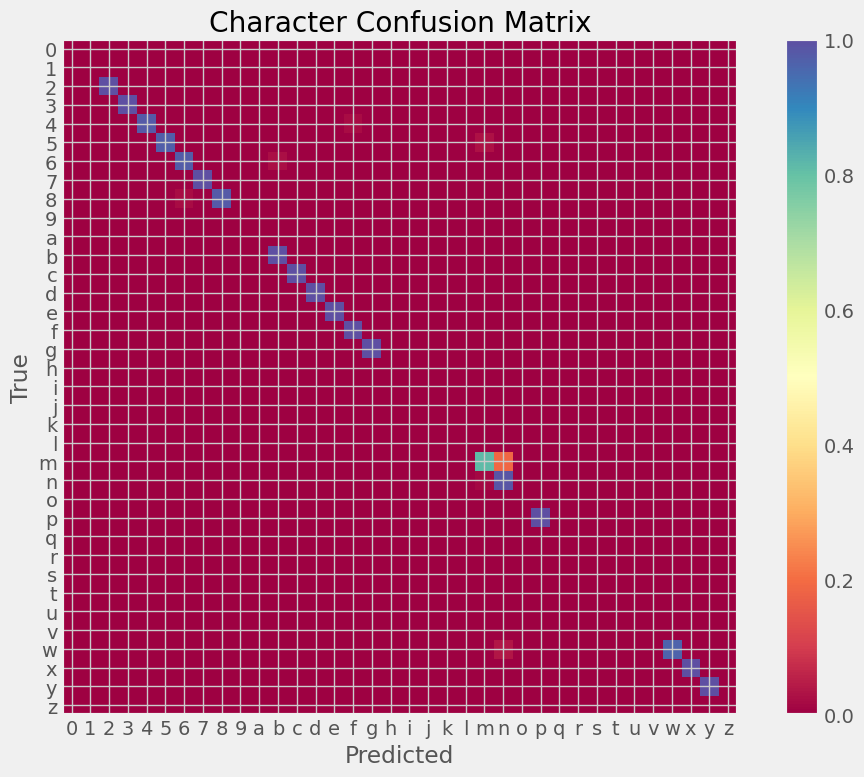

In [65]:
def evaluate_model(
    model, dataset, index_to_char, characters, max_length=None
):

    total_samples = 0
    correct_strings = 0
    
    total_chars = 0
    total_char_correct = 0
    
    total_edit_distance = 0
    
    # Confusion matrix
    confusion_matrix, char_to_idx_cm = build_confusion_matrix(characters)

    for images, labels in dataset:
        # Convert to NumPy
        images_np = images.numpy()
        labels_np = labels.numpy()

        # Predict
        predictions = model.predict(images_np)
        
        # ctc_decode
        batch_size_tf = tf.shape(predictions)[0]
        input_length = tf.fill([batch_size_tf], tf.shape(predictions)[1])
        decoded, _ = ctc_decode(predictions, input_length=input_length, greedy=True)
        # shape is (batch_size, decoded_seq_len)
        decoded = decoded[0].numpy() 

        for b in range(len(images_np)):
            # Ground truth label
            label_indices = labels_np[b]
            # Remove padding if present
            label_indices = [idx for idx in label_indices if idx != 0] 
            true_text = "".join(index_to_char[x] for x in label_indices)

            # Predicted label
            decoded_indices = decoded[b]
            if max_length:
                decoded_indices = decoded_indices[:max_length]
            decoded_indices = [idx for idx in decoded_indices if idx != -1]
            pred_text = "".join(index_to_char[x] for x in decoded_indices)

            # Full-string accuracy
            total_samples += 1
            if pred_text == true_text:
                correct_strings += 1

            # Character-level accuracy
            # Compare up to min(len(true_text), len(pred_text))
            matches = 0
            for c1, c2 in zip(true_text, pred_text):
                if c1 == c2:
                    matches += 1
            total_chars += max(len(true_text), len(pred_text))
            total_char_correct += matches

            # Edit distance
            dist = levenshtein_distance(true_text, pred_text)
            total_edit_distance += dist

            # Confusion matrix
            # Compare chars up to min(len(true_text), len(pred_text))
            for c1, c2 in zip(true_text, pred_text):
                update_confusion_matrix(confusion_matrix, char_to_idx_cm, c1, c2)

    full_string_accuracy = correct_strings / total_samples 
    char_accuracy = total_char_correct / total_chars 
    avg_edit_distance = total_edit_distance / total_samples 

    return {
        "full_string_accuracy": full_string_accuracy,
        "char_accuracy": char_accuracy,
        "avg_edit_distance": avg_edit_distance,
        "confusion_matrix": confusion_matrix
    }

metrics = evaluate_model(
    model=model,
    dataset=test_dataset,
    index_to_char=index_to_char,
    characters=characters,  
    max_length=max_label_length
)

print("Full-String Accuracy:", metrics["full_string_accuracy"])
print("Character-Level Accuracy:", metrics["char_accuracy"])
print("Average Edit Distance:", metrics["avg_edit_distance"])

conf_mat = metrics["confusion_matrix"]
print("Confusion Matrix shape:", conf_mat.shape)



plot_confusion_matrix(conf_mat, characters)

## Loss Over Epoch Chart

Lowest validation loss at epoch 1: 0.2083


C:\Users\Evan\AppData\Local\Temp\ipykernel_118416\3219389599.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


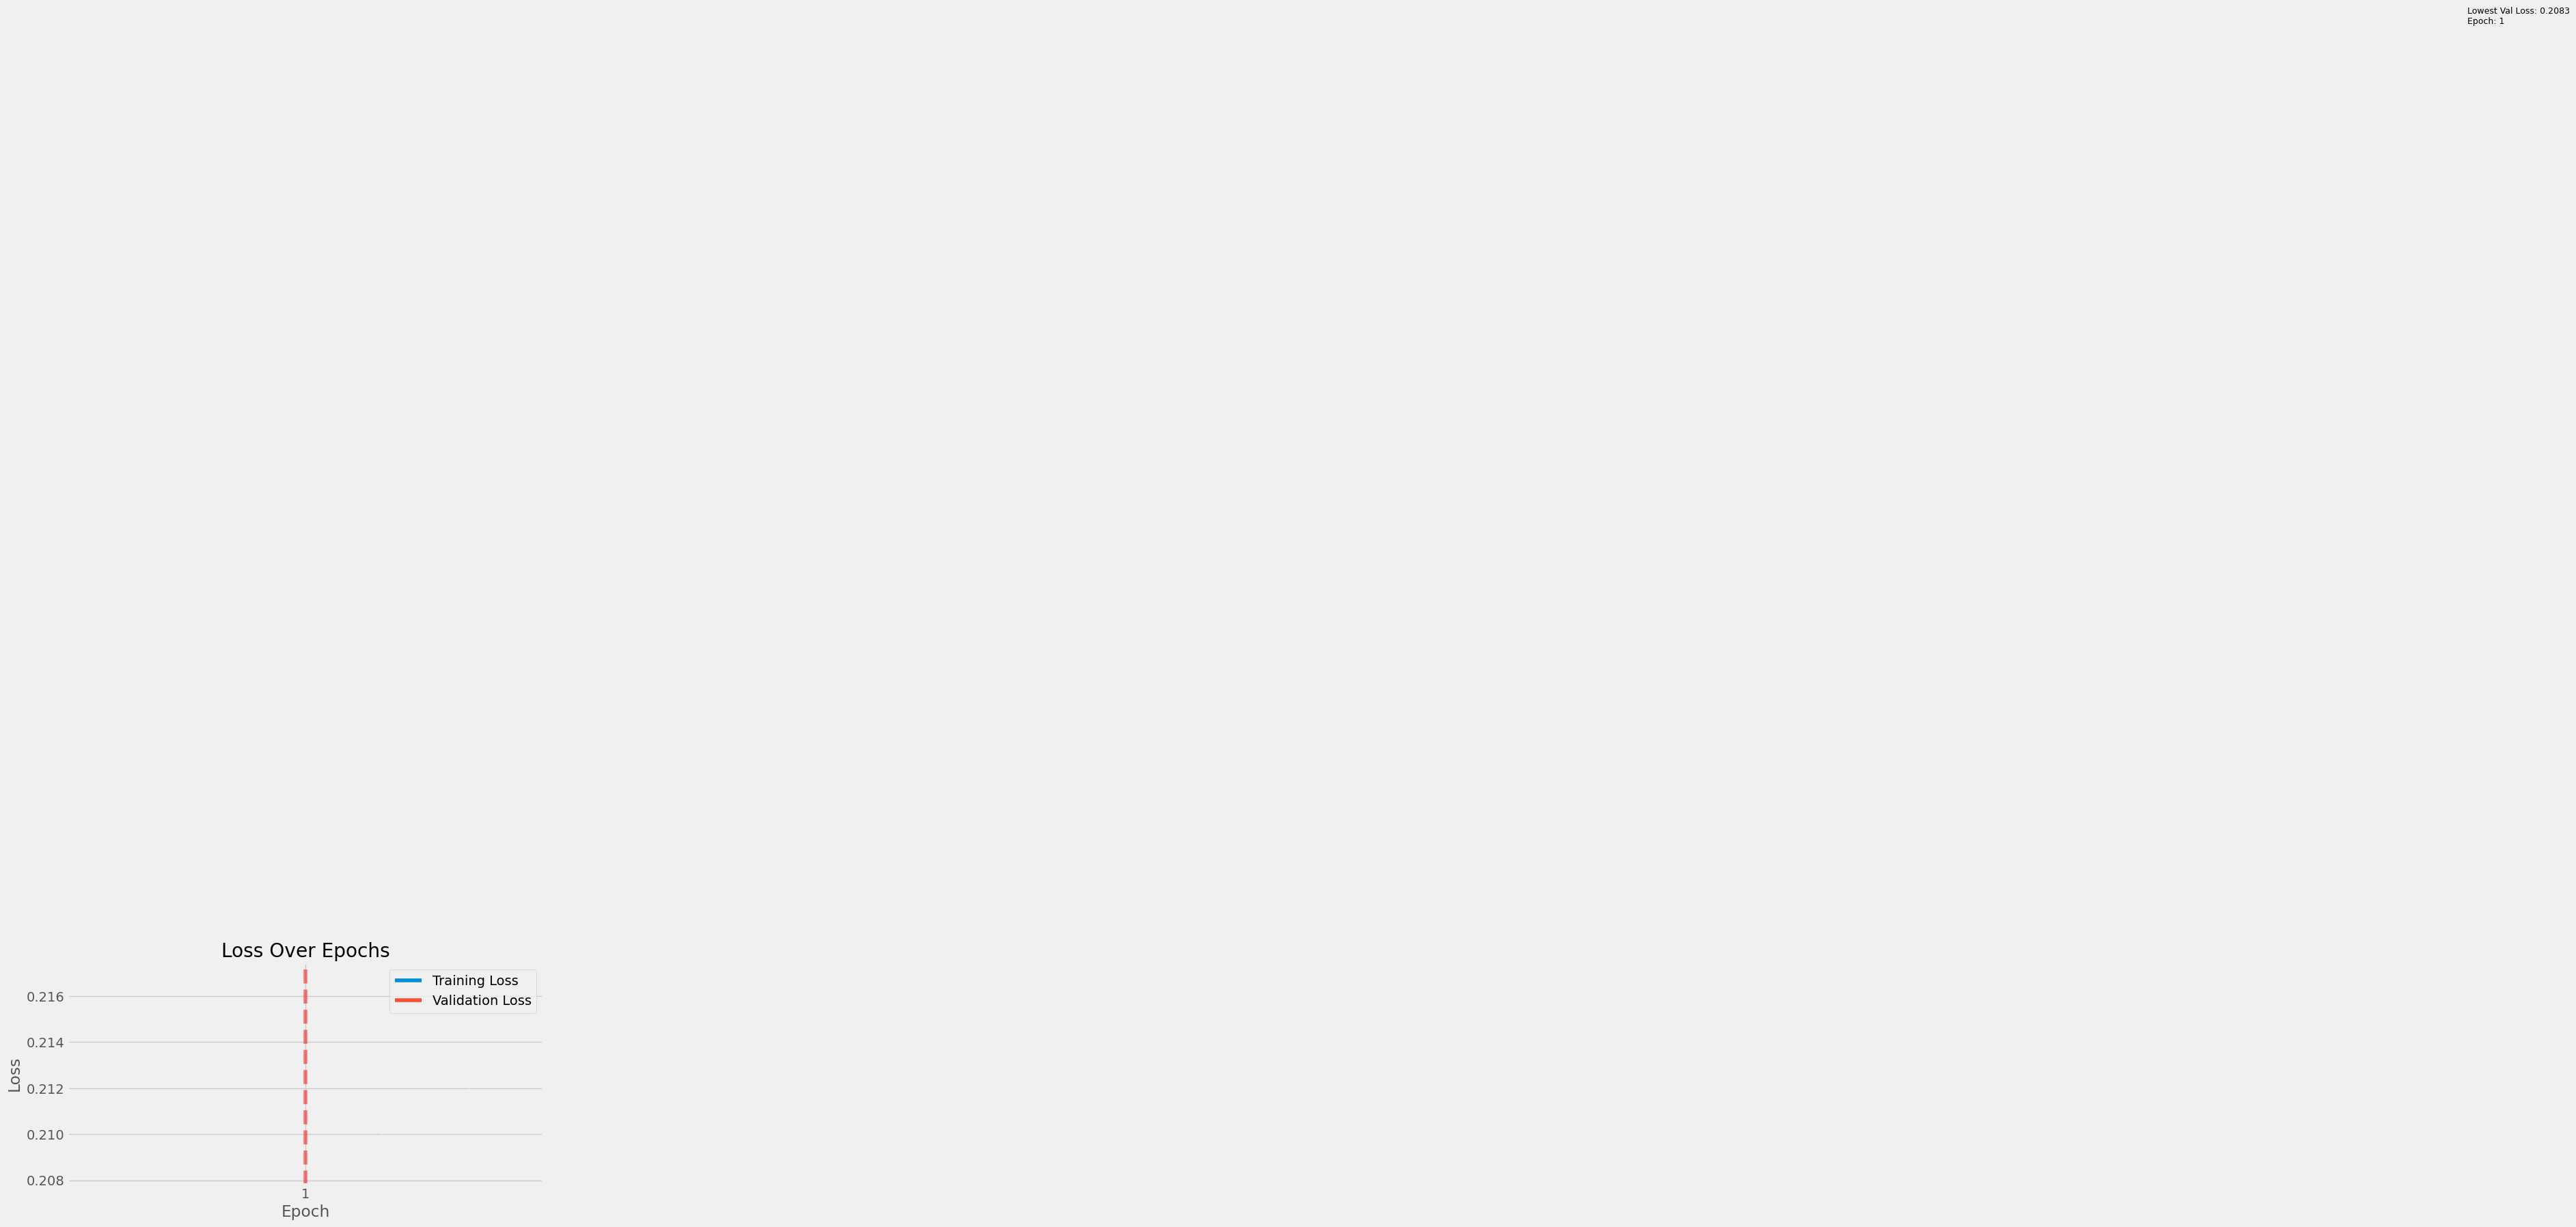

In [68]:
plt.style.use('fivethirtyeight')

def plot_loss_and_metrics(history, metrics_to_plot=None, annotate_best=True):
    # Receive training loss and validation loss data
    hist = history.history
    
    # Empty if no input
    if metrics_to_plot is None:
        metrics_to_plot = []

    # Find the epoch of the lowest val_loss
    best_epoch = None
    if 'val_loss' in hist:
        val_loss = hist['val_loss']
        best_epoch = np.argmin(val_loss)
        print(f"Lowest validation loss at epoch {best_epoch+1}: {val_loss[best_epoch]:.4f}")

    # Subplot figure for loss
    num_subplots = 1 + len(metrics_to_plot)
    fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 4 * num_subplots))
    
    if num_subplots == 1:
        axes = [axes]  

    # Plot training loss and validation loss
    ax_loss = axes[0]
    ax_loss.plot(hist['loss'], label='Training Loss')
    if 'val_loss' in hist:
        ax_loss.plot(hist['val_loss'], label='Validation Loss')
    ax_loss.set_title('Loss Over Epochs')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Highlight best epoch 
    if annotate_best and best_epoch is not None:
        min_val_loss = hist['val_loss'][best_epoch]
        ax_loss.annotate(
            f'Lowest Val Loss: {min_val_loss:.4f}\nEpoch: {best_epoch + 1}',
            xy=(best_epoch, min_val_loss),
            xytext=(best_epoch + 0.5, min_val_loss + 0.05),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=9
        )
        ax_loss.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)

    # Plot metrics if available
    for i, metric in enumerate(metrics_to_plot, start=1):
        ax = axes[i]

        train_metric_key = metric
        val_metric_key = 'val_' + metric

        train_values = hist.get(train_metric_key, None)
        val_values = hist.get(val_metric_key, None)

        # Catch empty values
        if train_values is None:
            print(f"Warning: Metric '{metric}' not found in history.")
            ax.set_title(f"Metric '{metric}' not found.")
            continue

        # Plot training loss
        ax.plot(train_values, label=f'Training {metric.title()}')
        if val_values is not None:
            ax.plot(val_values, label=f'Validation {metric.title()}')

        # Plot corresponding validation loss
        ax.set_title(f'{metric.title()} Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.title())
        ax.legend()

    # total number of epochs
    epochs = len(hist['loss'])  
    for ax in axes:
        # Create ticks at increments of 2 
        tick_positions = np.arange(0, epochs)
        ax.set_xticks(tick_positions)
        
        ax.set_xticklabels(tick_positions + 1)

    plt.tight_layout()
    plt.show()


plot_loss_and_metrics(history, metrics_to_plot=None, annotate_best=True)